<a href="https://colab.research.google.com/github/raunaqnayar/CIFAR10_autoencoder/blob/main/CIFAR10_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN autoencoder for Cifar-10 dataset

In [ ]:
from torchvision.datasets import CIFAR10;
import pickle;
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import torch;
import torch.nn as nn;
import torch.nn.functional as F;
from sklearn.model_selection import train_test_split;
from torch.utils.data import TensorDataset,DataLoader;

In [ ]:
cifar10=CIFAR10('sample_data',download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12831078.40it/s]


Extracting sample_data/cifar-10-python.tar.gz to sample_data


In [ ]:
cifar10.data.shape

(50000, 32, 32, 3)

In [ ]:
len(cifar10.targets)

50000

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
label_info=cifar10.classes

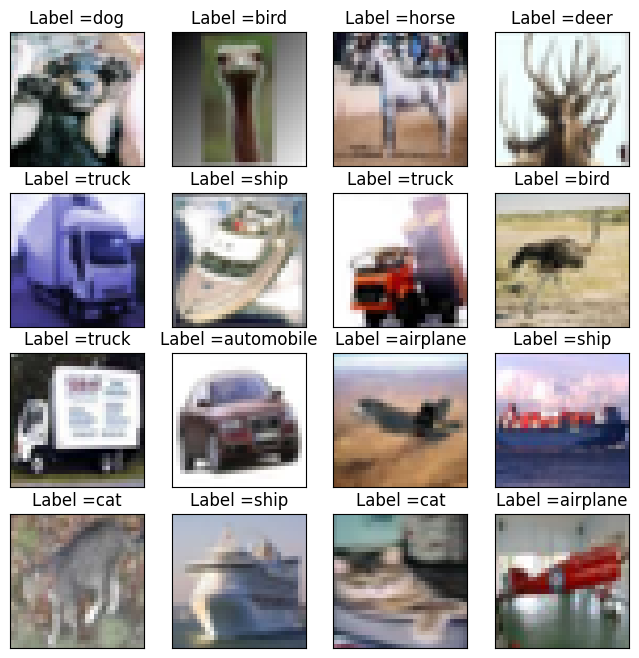

In [ ]:
 val=np.random.choice(range(len(cifar10.targets)),(4,4))

fig,ax=plt.subplots(4,4,figsize=(8,8))
for i in range(4):
  for j in range(4):
    ax[i][j].imshow(cifar10.data[val[i][j],:,:,:])
    #label=label_info[b'label_names'][inp1[b'labels'][val[i][j]]].decode("utf-8")
    ax[i][j].set_title('Label ='+label_info[cifar10.targets[val[i][j]]])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

In [ ]:
np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
inp_data=torch.Tensor(np.moveaxis(cifar10.data/255,[1,2,3],[2,3,1]))
target_data=torch.Tensor(cifar10.targets).long()

In [ ]:
inp_data.shape

torch.Size([50000, 3, 32, 32])

In [ ]:
target_data.shape

torch.Size([50000])

## Create CNN architecture for CIFAR10 Autoencoder

In [ ]:
def create_cifar10_CNN():
  class cifar10_autoencoder(nn.Module):
    def __init__(self):
      super().__init__();
      self.input_conv=nn.Conv2d(3,16,kernel_size=4,stride=2,padding=1)
      self.hidden1_batchnorm=nn.BatchNorm2d(16)
      self.hidden1_conv=nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1)
      self.hidden2_batchnorm=nn.BatchNorm2d(32)
      self.hidden2_conv=nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1)
      self.hidden3_batchnorm=nn.BatchNorm2d(64)
      self.hidden2_deconv=nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
      self.hidden2_deconv_batchnorm=nn.BatchNorm2d(32)
      self.hidden1_deconv=nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1)
      self.output_batchnorm=nn.BatchNorm2d(16)
      self.output=nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1)

    def forward(self,x):
      #print(x.shape)
      x=F.relu(self.input_conv(x));
      #print(x.shape)
      x=F.relu(self.hidden1_conv(self.hidden1_batchnorm(x)));
      #print(x.shape)
      x=F.relu(self.hidden2_conv(self.hidden2_batchnorm(x)));
      #print(x.shape)
      x=F.relu(self.hidden2_deconv(self.hidden3_batchnorm(x)));
      #print(x.shape)
      x=F.relu(self.hidden1_deconv(self.hidden2_deconv_batchnorm(x)));
      #print(x.shape)
      y=torch.sigmoid(self.output(self.output_batchnorm(x)));
      return y
  model=cifar10_autoencoder();
  lossfun=nn.MSELoss();
  optimizer=torch.optim.Adam(model.parameters(),lr=0.002);
  return model,lossfun,optimizer;

#### Check if the architecture is correct

In [ ]:
temp=create_cifar10_CNN()[0]
temp(torch.randn([7,3,32,32])).shape

torch.Size([7, 3, 32, 32])

## Train the CIFAR-10 data on the created CNN model

In [ ]:
X_train,X_valtest=train_test_split(inp_data,test_size=0.2);
X_val,X_test=train_test_split(X_valtest,test_size=0.5);
#train_dataset=TensorDataset(X_train,y_train);
#val_dataset=TensorDataset(X_val,y_val);
#test_dataset=TensorDataset(X_test,y_test);
train_dataset=DataLoader(X_train,batch_size=64,shuffle=True);
val_dataset=DataLoader(X_val,batch_size=X_val.shape[0]);
test_dataset=DataLoader(X_test,batch_size=X_test.shape[0]);

In [ ]:
def train_cifar10():

  device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

  CNN_model, lossfun, optimizer=create_cifar10_CNN();



  num_epochs=10;
  trainLoss=np.zeros(num_epochs);
  testLoss=np.zeros(num_epochs);

  for i in range(num_epochs):
    batchLoss=[];
    CNN_model.train();
    CNN_model.to(device);

    for X in train_dataset:
      X=X.to(device);
      yHat=CNN_model(X);
      loss=lossfun(yHat,X)
      optimizer.zero_grad();
      loss.backward();
      optimizer.step();
      batchLoss.append(loss.detach().cpu().item());
    trainLoss[i]=np.mean(batchLoss)
    CNN_model.eval();
    with torch.no_grad():
      X=next(iter(val_dataset))
      X=X.to(device);
      yHat=CNN_model(X);
      loss=lossfun(yHat,X)
      testLoss[i]=loss.detach().cpu().item();


  return CNN_model,trainLoss,testLoss


In [ ]:
cifar10_autoencoder_model, trainLoss,valLoss = train_cifar10();

In [ ]:
cifar10_autoencoder_model.eval()
with torch.no_grad():
  X=next(iter(test_dataset))
  X=X.to(device);
  yHat=cifar10_autoencoder_model(X);
  testLoss=nn.MSELoss()(yHat,X).detach().item()

Text(0, 0.5, 'Loss')

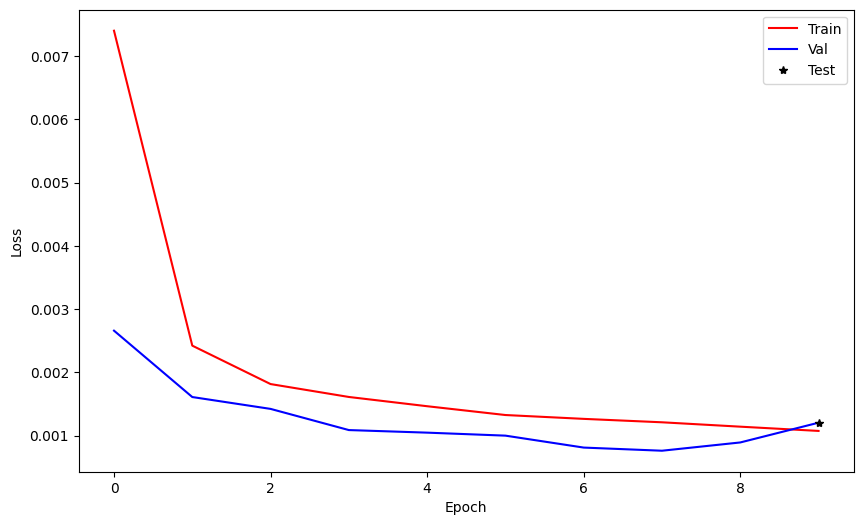

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.plot(range(10),trainLoss,'r')
ax.plot(range(10),valLoss,'b')
ax.plot(9,testLoss,'k*')
ax.legend(['Train','Val','Test'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
print("CIFAR10 dataset Autoencoder:")
print("Training Loss (40000 images) is:",trainLoss[-1])
print("Validation Loss (5000 images) is: ",valLoss[-1])
print("Test Batch Loss (5000 images) is: ",testLoss)

CIFAR10 dataset Autoencoder:
Training Loss (40000 images) is: 0.0010728767916560174
Validation Loss (5000 images) is:  0.0012030472280457616
Test Batch Loss (5000 images) is:  0.0012052498059347272


In [ ]:
X=X.cpu()
yHat=yHat.cpu()

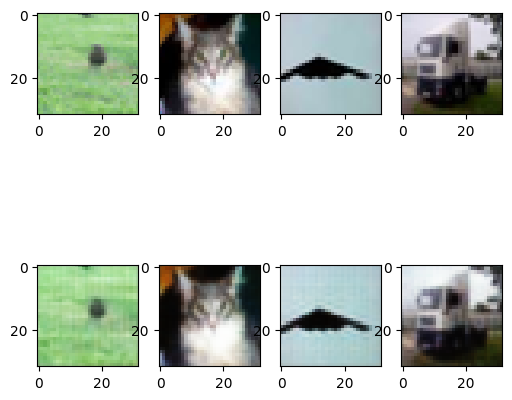

In [ ]:
temp=np.random.choice(5000,4)
fig,ax=plt.subplots(2,4,figsize=(6,6))
for i in range(4):
    ax[0][i].imshow(X[temp[i],:,:,:].permute(1,2,0))
    ax[1][i].imshow(yHat[temp[i],:,:,:].permute(1,2,0))